In our setting, a scoring model generates scores to identify individuals who benefit the most from treatment. This notebook provides an example where we apply a correction to the scoring model and compare it with a causal-effect model learned from experimental data. 

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV, train_test_split

# Causal tree
from deconfounder.causal_tree import CausalTree

# Deconfounder
from deconfounder.deconfound_estimator import DeconfoundEstimator
from deconfounder.deconfound_classifier import DeconfoundClassifier
from deconfounder.deconfound_ranker import DeconfoundRanker

# Evaluation metrics
from metrics import mean_squared_error, causal_impact, auuc_score, uplift_curve

In [2]:
## Data generation functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def array_with_same_sign(arr):
    '''
    Return: an array with a uniform random distribution, where each element shares 
    the same sign as the corresponding element in the input array.
    '''
    k = len(arr)
    m = (arr >= 0)
    new_arr = m * np.random.uniform(0, 1, size=k) + (~m) * np.random.uniform(-1, 0, size=k)
    return new_arr

def array_with_same_order(arr):
    '''
    Return: an array with a uniform random distribution, where the elements maintain 
    the same order as in the input array.
    '''
    k = len(arr)
    m = (arr >= 0)
    order = np.argsort(arr)
    rank = np.argsort(order)
    new_arr_pos = np.sort(np.random.uniform(0, 1, size=k))[rank]
    new_arr_neg = np.sort(np.random.uniform(-1, 0, size=k))[rank]
    new_arr = m * new_arr_pos + (~m) * new_arr_neg

    # assert(np.array_equal(np.argsort(arr[m]), np.argsort(new_arr[m])))
    # assert(np.array_equal(np.argsort(arr[~m]), np.argsort(new_arr[~m])))

    return new_arr

class DataGenerator:
    '''
    - n_features: Number of features
    - keep_order: If True, the alpha array keeps the same order as beta; Otherwise alpha
      has the same sign as beta.
    - alpha_0: coefficient of u for y0, adjust confounding strength
    - noise_scale_c: standard deviation of noise for treatment effect
    - noise_scale_y0: standard deviation of noise for control outcome
    - noise_scale_x: standard deviation of noise for X
    '''

    def __init__(
        self, 
        n_features, 
        keep_order=False, 
        alpha_0 = 1.0,
        noise_scale_c=0.0, 
        noise_scale_y0=0.0,
        noise_scale_x=0.0
    ):
        
        self.n_features = n_features
        self.keep_order = keep_order
        self.alpha_0 = alpha_0
        self.noise_scale_c = noise_scale_c
        self.noise_scale_y0 = noise_scale_y0
        self.noise_scale_x = noise_scale_x

    def reset_coef(self):
        '''
        Return:
            - beta: Coefficient of X for C.
            - alpha: Coeficient of U for X.
        '''
        k = self.n_features
        
        beta = np.random.uniform(-1, 1, size=k)     
        if self.keep_order:
            alpha = array_with_same_order(beta)
        else:
            alpha = array_with_same_sign(beta)  

        self.beta = beta
        self.alpha = alpha

    def treatment_effect(self, X):

        beta = self.beta
        beta_0 = 0
        x_beta = np.squeeze(np.dot(X, beta[:, np.newaxis]))
        eff = x_beta + beta_0
        return eff

    def control_outcome(self, X, u):

        alpha_0 = self.alpha_0
        noise_scale = self.noise_scale_y0
        noise_y0 = np.random.normal(0, noise_scale, size=X.shape[0])
        y0 = u * alpha_0 + noise_y0
        return y0
    
    def covariate(self, u):
        
        n = u.shape[0]
        k = self.n_features
        noise_scale = self.noise_scale_x
        noise_x = np.random.normal(0, noise_scale, size=(n, k))
        p = np.dot(u[:, np.newaxis], self.alpha[np.newaxis, :]) + noise_x
        p = sigmoid(p)
        X = np.random.binomial(1, p=p, size=(n, k))
        return X

    def generate_data(self, n, is_exp=True):

        noise_scale_c = self.noise_scale_c

        # Unobserved 
        u = np.random.uniform(0, 1, size=n) 
        
        # Covariate
        X = self.covariate(u)

        # treatment effect
        c = self.treatment_effect(X)
        noise_c = np.random.normal(0, noise_scale_c, size=n)

        # control outcome
        y0 = self.control_outcome(X, u)

        # treatment
        if is_exp:
            p_t = 0.5
        else:
            p_t = u.copy()
        t = np.random.binomial(1, p=p_t, size=n)

        y = y0 + (c + noise_c) * t

        return X, t, y, c, y0
    
    def estimate_conf_cate(self, x, n=5000):
        '''
        Assuming all the relationships among variables are known, given a feature vector x, 
        estimate E(Y|T=1, X)-E(Y|T=0, X) among a grid of u values with n points.
        
        The estimation is: alpha_0 * (E(U|T=1,X)-E(U|T=0,X))+E(C|X), where
        E(U|T,X) = \sum_u u * P(U=u|T, X) 
        '''
        
        alpha = self.alpha
        beta = self.beta
        alpha_0 = self.alpha_0

        eff = np.sum(beta * x)

        u = np.linspace(0, 1, num=n)

        p_x = sigmoid(np.dot(u[:, np.newaxis], alpha[np.newaxis, :]))    # (n, k)
        p_t = u     # (n,)

        p_u = 1 / n
        p_x_u = np.prod(x * p_x + (1-x) * (1-p_x), axis=1)  # (n, )
        
        p_uxt = p_u * p_x_u * p_t       
        p_uxc = p_u * p_x_u * (1-p_t)

        p_xt = np.sum(p_uxt)
        p_xc = np.sum(p_uxc)

        res_t = np.sum(u * p_uxt)
        res_c = np.sum(u * p_uxc)

        res = alpha_0 * (res_t / p_xt - res_c / p_xc) + eff
        return res
    


The confounded data is simulated, and the diagram below illustrates the relationships among the variables. Here, X represents the features, T represents the treatment, C is the treatment effect, Y0 is the control outcome, and U represents the unobserved confounder. 
* $C = \beta\cdot X + \epsilon$, where $\beta \sim Uniform(-1,1)$, $\epsilon$ represnts the noise following normal distribution
* $U \sim Uniform(0, 1)$
* $T \sim Bernoulli(p=U)$
* $Y_0 = \alpha_0\cdot U + \epsilon$, where $\alpha_0$ is a parameter value, adjusting the confounding strength.
* $X \sim Bernouli(p=sigmoid(\alpha\cdot U+\epsilon))$, where $\alpha$ is a vector with feature size, where $\alpha_i$ satisfies that $\alpha_i\cdot\beta_i>0$, $\alpha_i\sim Uniform(0,1)$ if $\alpha_i>0$, else $\alpha_i\sim Uniform(-1, 0)$


U correlates with both T and Y0, leading to confounding. In addition, X correlates with U, thus different X has different degree of confounding. $\beta$ and $\alpha$ share the same signs, ensuring that confounding has the same direction as the effects. Also, T and Y0 increase as U increases. Consequently, X with smaller effects but higher confounding is likely to be estimated to have greater effects compared to X with larger effects but lower confounding. This will disrupt rankings.

```
T
|
U —— X —— C
|
Y0
```

Below is a toy example showing how the ranking is disrupted within this data generation framework. We estimate treatment effects, assuming that all relationships among the variables are known, based on $E(Y|T=1, X)-E(Y|T=0, X)$. We then compare the rankings by the effect estimates with the rankings of the true effects.

In [3]:
# Generate data
dg_toy = DataGenerator(
    n_features=100,
    keep_order=False,
    alpha_0=10.0,
)

dg_toy.reset_coef()

n_toy = 300
X_toy, t_toy, y_toy, c_toy, y0_toy = dg_toy.generate_data(n_toy, is_exp=False)

# Estimate effects
c_est = []
for i in range(n_toy):
    c_est.append(dg_toy.estimate_conf_cate(X_toy[i], n=3000))
c_est = np.array(c_est)

The fluctuations in the plot indicate that their ordering are not entirely consistent.

Text(0, 0.5, 'Estimated Effect')

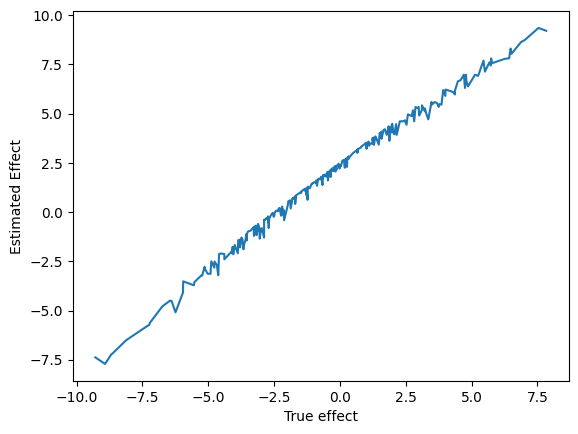

In [4]:
order = np.argsort(c_toy)

plt.plot(c_toy[order], c_est[order])
plt.xlabel('True effect')
plt.ylabel('Estimated Effect')

This generated data is used to conduct experiments.

In [5]:
seed = 42
np.random.seed(seed)

dg = DataGenerator(
    n_features=150,
    keep_order=False,
    alpha_0=10.0,
    noise_scale_c=1.0,
    noise_scale_y0=0.1,
    noise_scale_x=0.1
)

dg.reset_coef()

## Observational data
n_obs = 50000
X_obs, t_obs, y_obs, c_obs, y0_obs = dg.generate_data(n_obs, is_exp=False)

## Test data (experimental data)
n_test = 10000
X_test, t_test, y_test, c_test, y0_test = dg.generate_data(n_test, is_exp=True)


Considering two scenarios:
* There is a large amoung of confounded observational data; 
* Only control data is available.

Two scoring models for the scenarios respectively: 
* A causal-effect model on the confounded data; 
* A predictive model on the control outcome.

In [6]:
def power2(min_num, max_num, scaler=1):

    grid = []
    num = scaler
    while num < min_num:
        num *= 2
    while num < max_num:
        grid.append(num)
        num *= 2
    return grid

def evaluate(eff_true, y_true, scores, treatment):

    mse = mean_squared_error(eff_true, scores)
    auuc = auuc_score(y_true, scores, treatment)
    decisions = (scores > 0)
    causal_imp = causal_impact(eff_true, decisions)

    return mse, causal_imp, auuc

In [7]:
res_sm = []

# Causal tree on confounded data
sm_cate = CausalTree(random_state=seed, min_samples_leaf=100)
sm_cate.fit(X_obs, np.c_[t_obs, y_obs])
conf_cate = sm_cate.predict(X_test)

mse, causal_imp, auuc = evaluate(c_test, y_test, conf_cate, t_test)
res_sm.append({'target': 'conf_cate', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

# Decision tree for y0 
sm_y0 = DecisionTreeRegressor(random_state=seed, min_samples_leaf=100)
sm_y0.fit(X_obs, y0_obs)
y0_pred = sm_y0.predict(X_test)
res_sm.append({'target': 'y0', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

res_df = pd.DataFrame(res_sm)
res_df.to_csv(f"../results/obs/scoring_model.csv", index=False)


Both scoring models perform better than the ATE, but there is still room for improvement compared to the true effects. The scoring model for Y0 performs better than the model for confounded CATE.

In [8]:
## Plots
def plot_uplift_curves(y, t, scores_dict, n_bins=100):

    n = y.shape[0]
    y, t = np.array(y), np.array(t)
    ate = y[t==1].mean() - y[t==0].mean()
    plt.plot([0, n], [0, ate*n], label='Random')

    for label, scores in scores_dict.items():
        curve_values = uplift_curve(y, scores, t, n_bins)
        plt.plot(curve_values[0], curve_values[1], label=label)

    plt.xlabel('Numer of targeted')
    plt.ylabel("Increment")
    plt.legend()
    plt.show()

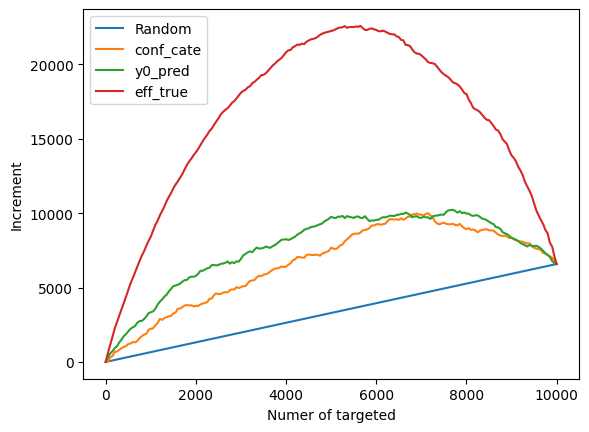

In [9]:
# Scoring model
scores_dict = {
    'conf_cate': conf_cate, 
    'y0_pred': y0_pred,
    'eff_true': c_test
}

plot_uplift_curves(y_test, t_test, scores_dict, n_bins=200)


Deconfounders are built on scores and learn from the experimental data to predict corrections. There are three types of deconfounders, each with distinct optimization objective: (1) effect estimation (EE); (2) effect classification (EC); (3) effect ordering (EO). 

We compare the performance of deconfounders to a causal effect model that is learned from scratch using the experimental data. We vary the experimental data size and repeat experiments with different random seeds.

Three evaluation metrics:
* MSE of the treatment effects
* Causal impact: $P(d=1)\cdot E(c|d=1)$, $d_i = \mathbf{1}[score_i>0]$
* AUUC (Area Under Uplift Curve)

In [10]:
def fit_causal_tree(X, t, y, tune=False, cv=5, seed=42, n_jobs=1):
    
    n = X.shape[0]
    model = CausalTree(random_state=seed)
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        model.min_samples_leaf = min(100, int(0.1*n))
        model.fit(X, np.c_[t, y])
    return model

dcf_dict = {
    'EE': DeconfoundEstimator(),
    'EC': DeconfoundClassifier(),
    'EO': DeconfoundRanker(n_trees=10, n_levels=10, subsample=1, max_features=0.3)
}

def fit_deconfounder(X, t, y, scores, method='EE', tune=False, 
        cv=5, seed=42, n_jobs=1):

    n = X.shape[0]
    model = copy(dcf_dict[method])
    model.random_state = seed
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y, scores])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        if method == 'EO':
            model.min_samples_leaf = int(0.05 * n)
            model.max_buckets = max(200, int(0.1 * n)) 
        else:
            model.min_samples_leaf = min(100, int(0.1*n))
        model.fit(X, np.c_[t, y, scores])
    return model
    


In [11]:
dcf_types = ['EE', 'EC', 'EO']
targets = ['conf_cate', 'y0']

exp_size_grid = power2(100, 50000, scaler=100)

for seed in tqdm(range(20)):
    np.random.seed(seed)
    res = []
    for exp_size in exp_size_grid:
    
        # Generate data
        X_exp, t_exp, y_exp, eff_exp, y0_exp = dg.generate_data(exp_size, is_exp=True)

        # Causal tree
        ct = fit_causal_tree(X_exp, t_exp, y_exp, seed=seed)
        cate_pred = ct.predict(X_test)
        mse, causal_imp, auuc = evaluate(c_test, y_test, cate_pred, t_test)
        res.append({'model': 'CT', 'exp_size': exp_size, 'mse': mse,'causal_imp': causal_imp, 'auuc': auuc})

        # Deconfounder
        for dcf_type in dcf_types:
            for target in targets:
                if target == 'conf_cate':
                    scores = sm_cate.predict(X_exp)
                    scores_test = conf_cate.copy()
                elif target == 'y0':
                    scores = sm_y0.predict(X_exp)
                    scores_test = y0_pred.copy()

                dm = fit_deconfounder(X_exp, t_exp, y_exp, scores, dcf_type, seed=seed)
                corrected_scores = scores_test - dm.predict(X_test)
                mse, causal_imp, auuc = evaluate(c_test, y_test, corrected_scores, t_test)
                model_name = f"{target}+{dcf_type}"  
                res.append({'model': model_name, 'exp_size': exp_size, 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})
    
    res_df = pd.DataFrame(res)
    res_df.to_csv(f"../results/exp/{seed}.csv", index=False)


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [05:54<00:00, 17.75s/it]


Experimental Results for the following models:
* CT - Causal Tree
* SM (conf_cate) - Scoring model for confounded CATE
* SM (y0) - Scoring model for Y0
* EE, EC, EO - Deconfounder for effect estimation, effect classification, effect ordering respectively

In [12]:
res_sm = pd.read_csv("../results/obs/scoring_model.csv")

In [13]:
res_dir = "../results/exp"
res_df = pd.DataFrame()
for fname in os.listdir(res_dir):
    filepath = os.path.join(res_dir, fname)
    res_i = pd.read_csv(filepath)
    res_df = pd.concat([res_df, res_i])

res_df = res_df.groupby(by=['model', 'exp_size']).mean().reset_index()

In [14]:
# Add a horizontal line
def plot_metric_curve(metric, methods=['CT','EE', 'EC', 'EO']):

    targets = ['conf_cate', 'y0']

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    for i, target in enumerate(targets):
        ax[i].axhline(y=res_sm.loc[res_sm.target==target, metric].values[0], linestyle='--', color='black', label=f'{target}')
        for m in methods:
            if m == 'CT':
                ax[i].plot(range(len(exp_size_grid)), res_df.loc[res_df.model==m, metric], label=m)
            else:
                model_name = f"{target}+{m}" 
                ax[i].plot(range(len(exp_size_grid)), res_df.loc[res_df.model==model_name, metric], label=model_name)
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel('Experimental data size (100 * 2^x)')
        ax[i].legend()
    plt.show()

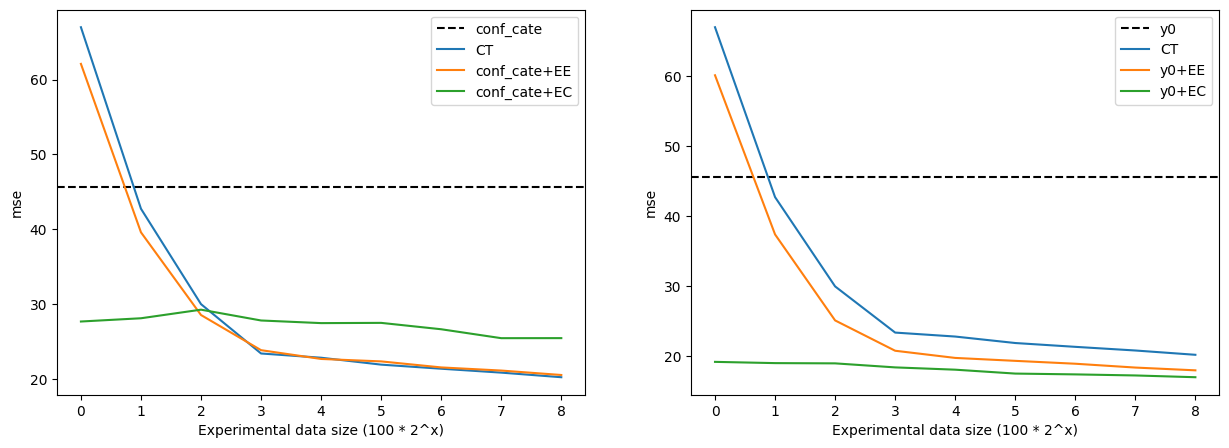

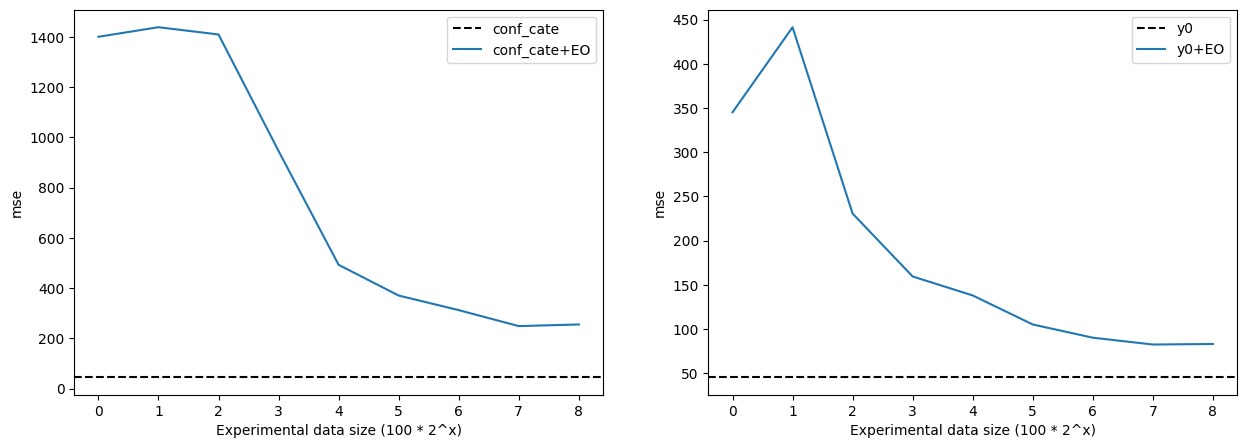

In [15]:
plot_metric_curve('mse', methods=['CT', 'EE', 'EC'])
plot_metric_curve('mse', methods=['EO'])

* EO starts with a very large MSE, but the MSE descrease as the data size increases.
* EC starts with the lowest MSE compared to other models, but its MSE decreases slightly with an increasing data size.
* EE's MSE drops as the data size increases, and its MSE is lower than SM model when the data size exceeds 200. 
* CT shows similar trend to EE. but its MSE is a bit higher than EE.

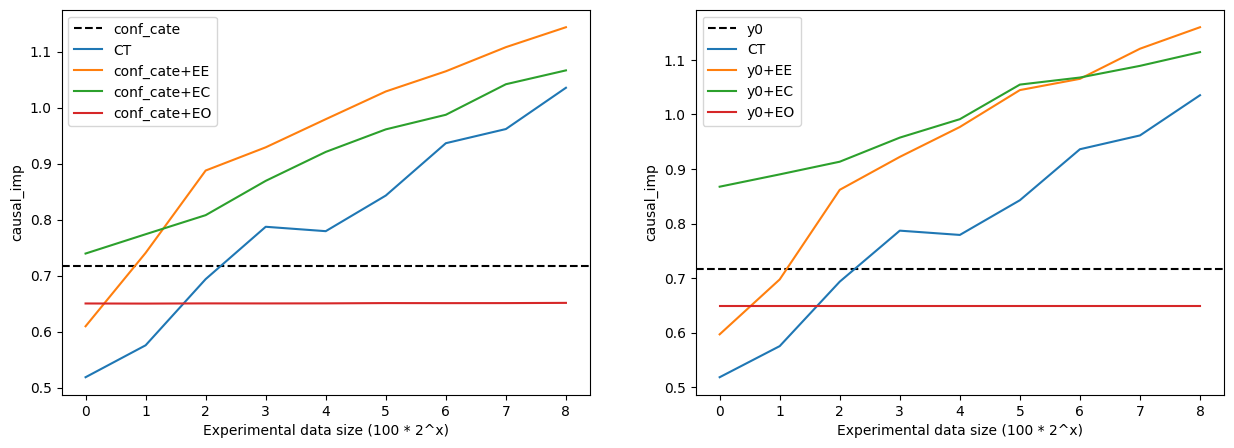

In [16]:
plot_metric_curve('causal_imp')

* EO has low causal impact value and this value hardly varies with the amount of data.
* EE and EC models outperform the SM model with a smaller data size compared to the CT model, but the CT shows a tendency to outperform both models as the data becomes larger. With the SM (conf_cate), EE perform best; with the SM (y0), EC performs best in the early stage, but it is outperformed by EE when the data size is greater than 6400.

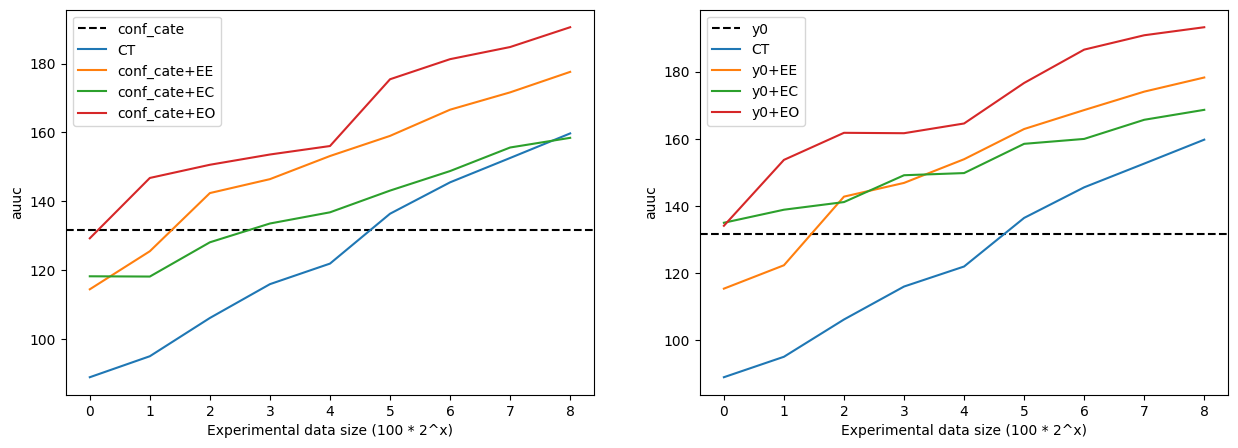

In [17]:
plot_metric_curve('auuc')

* Deconfounders surpass the SM models earlier compared to CT. 
* EO demonstrates superior performance across all models.